# ASHRAE - The Great Energy Predictor (Mock Submission)

*The following code has been modified by myself. It's original code is from Kaggle user Koustav Banerjee*

In [354]:
#Data Cleaning and Organizing
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
import gc


#pre processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Modeling
import xgboost as xgb
import time
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score

# First look at the data

In [355]:
#each data set, not included in github
buildMetData = pd.read_csv('energyCSV/building_metadata.csv')
test = pd.read_csv('energyCSV/test.csv')
train = pd.read_csv('energyCSV/train.csv')
weatherTest = pd.read_csv('energyCSV/weather_test.csv')
weatherTrain = pd.read_csv('energyCSV/weather_train.csv')

train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [356]:
## Function to reduce the df size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [357]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

weatherTrain = reduce_mem_usage(weatherTrain)
weatherTest = reduce_mem_usage(weatherTest)
buildMetData = reduce_mem_usage(buildMetData)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [358]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997


In [359]:
print(train.info(), test.info(), weatherTrain.info(), weatherTest.info(), buildMetData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int16  
 1   meter          int8   
 2   timestamp      object 
 3   meter_reading  float32
dtypes: float32(1), int16(1), int8(1), object(1)
memory usage: 289.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   row_id       int32 
 1   building_id  int16 
 2   meter        int8  
 3   timestamp    object
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 596.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int8   
 1   timestamp           139773 non-null  object 


## Pre-processing

The 'timestamp' coloumns in 'train', 'test', 'weatherTrain', 'weatherTest' - as well as the column 'primary_use' in BuildMetData - are currently an onject type. Need to change those formats into something more usable.

In [360]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

weatherTrain['timestamp'] = pd.to_datetime(weatherTrain['timestamp'])
weatherTest['timestamp'] = pd.to_datetime(weatherTest['timestamp'])

In [361]:
print(train.info(), test.info(), weatherTrain.info(), weatherTest.info(), buildMetData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   row_id       int32         
 1   building_id  int16         
 2   meter        int8          
 3   timestamp    datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(1), int8(1)
memory usage: 596.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------

As the data is currently 'timestamp' presents itself as a single moment in time. A single hour for every day. this can be broken into further cartegories: 'hour', 'day', 'weekend', & 'month'. This recategorizing could help us find trends in specific, months, days, or even hours for the data to find trends in.

In [362]:
train

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000000
1,1,0,2016-01-01 00:00:00,0.000000
2,2,0,2016-01-01 00:00:00,0.000000
3,3,0,2016-01-01 00:00:00,0.000000
4,4,0,2016-01-01 00:00:00,0.000000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000
20216096,1445,0,2016-12-31 23:00:00,4.825000
20216097,1446,0,2016-12-31 23:00:00,0.000000
20216098,1447,0,2016-12-31 23:00:00,159.574997


In [363]:
train["hour"] = train["timestamp"].dt.hour
train["day"] = train["timestamp"].dt.day
train["weekday"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

test["hour"] = test["timestamp"].dt.hour
test["day"] = test["timestamp"].dt.day
test["weekday"] = test["timestamp"].dt.weekday
test["month"] = test["timestamp"].dt.month

In [364]:
train

,building_id,meter,timestamp,meter_reading,hour,day,weekday,month
0,0,0,2016-01-01 00:00:00,0.000000,0,1,4,1
1,1,0,2016-01-01 00:00:00,0.000000,0,1,4,1
2,2,0,2016-01-01 00:00:00,0.000000,0,1,4,1
3,3,0,2016-01-01 00:00:00,0.000000,0,1,4,1
4,4,0,2016-01-01 00:00:00,0.000000,0,1,4,1
...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,23,31,5,12
20216096,1445,0,2016-12-31 23:00:00,4.825000,23,31,5,12
20216097,1446,0,2016-12-31 23:00:00,0.000000,23,31,5,12
20216098,1447,0,2016-12-31 23:00:00,159.574997,23,31,5,12


In [365]:
#Merging Train, BuildMetData, weatherTrain
trainBuild = train.merge(buildMetData, on=['building_id'], how='left')
train = trainBuild.merge(weatherTrain, on=['site_id','timestamp'], how='left')

#Merging Test, BuildMetData, weatherTest
testBuild = test.merge(buildMetData, on=['building_id'], how='left')
test = testBuild.merge(weatherTest, on=['site_id','timestamp'], how='left')

In [366]:
#We don't need time stamp anymore
train = train.drop("timestamp", axis = 1)
test = test.drop("timestamp", axis = 1)

Now that 'timestamp' is taken care, let's label encode 'primary_use'.

In [367]:
#Label encoding primary_use so that the model can run
le = LabelEncoder()

train['primary_use'] = le.fit_transform(train['primary_use']).astype(np.int8)
test['primary_use'] = le.fit_transform(test['primary_use']).astype(np.int8)

In [368]:
train

,building_id,meter,meter_reading,hour,day,weekday,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0.000000,0,1,4,1,0,0,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,0.000000,0,1,4,1,0,0,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,0.000000,0,1,4,1,0,0,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,0.000000,0,1,4,1,0,0,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,0.000000,0,1,4,1,0,0,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750000,23,31,5,12,15,1,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,4.825000,23,31,5,12,15,0,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,0.000000,23,31,5,12,15,1,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,159.574997,23,31,5,12,15,4,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


# Featuring Engineering

There are a couple things that should be considered as we move forward.
- a lot of the data in this set is still left as null, inf, or empty. This can be delt with later but the biggest offender is floor_count
- This data was given pre train-test split
- Data is to big to merge train and test to create a train-test split via sklearn
- Some of the data needs to be label encoded because models don't like strings
- Timestamp is no longer needed since we have split it into deeper, separate columns

In [369]:
train

,building_id,meter,meter_reading,hour,day,weekday,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0.000000,0,1,4,1,0,0,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,0.000000,0,1,4,1,0,0,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,0.000000,0,1,4,1,0,0,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,0.000000,0,1,4,1,0,0,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,0.000000,0,1,4,1,0,0,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750000,23,31,5,12,15,1,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,4.825000,23,31,5,12,15,0,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,0.000000,23,31,5,12,15,1,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,159.574997,23,31,5,12,15,4,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [370]:
train

,building_id,meter,meter_reading,hour,day,weekday,month,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0.000000,0,1,4,1,0,0,7432,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,0.000000,0,1,4,1,0,0,2720,2004.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,0.000000,0,1,4,1,0,0,5376,1991.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,0.000000,0,1,4,1,0,0,23685,2002.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,0.000000,0,1,4,1,0,0,116607,1975.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750000,23,31,5,12,15,1,19619,1914.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,4.825000,23,31,5,12,15,0,4298,NaN,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,0.000000,23,31,5,12,15,1,11265,1997.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,159.574997,23,31,5,12,15,4,29775,2001.0,NaN,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


# Dealing with Cat, Num, Features and dropping unnecessary Features

In [371]:
# creating a list if feat columns and drop columns for later indexing in train-test split
featCols = ['building_id', 'primary_use', 'hour', 'day', 'weekday', 'month', 'meter', 'square_feet', 'year_built', 'air_temperature', 'cloud_coverage', 'dew_temperature']

dropCols = ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

In [372]:
valTarget = np.log1p(train["meter_reading"])
del train["meter_reading"]

In [373]:
train = train.drop(dropCols + ["site_id", "floor_count"], axis = 1)
test = test.drop(dropCols + ["site_id", "floor_count","row_id"], axis = 1)

In [374]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   building_id      int16  
 1   meter            int8   
 2   hour             int64  
 3   day              int64  
 4   weekday          int64  
 5   month            int64  
 6   primary_use      int8   
 7   square_feet      int32  
 8   year_built       float16
 9   air_temperature  float16
 10  cloud_coverage   float16
 11  dew_temperature  float16
dtypes: float16(4), int16(1), int32(1), int64(4), int8(2)
memory usage: 1.1 GB


# Modelling

Using KFolds and cross validating with LightGBM. There's a protion of the script that is commented out. That's because the original coder only trained on the first 80% of the data and then validated on the last 20%. This was his way of keeping the script quicker and easier to manager.

For sure this is a valid way to go, and I urge anyone with a less computationally powerful computer uncomment lines 8 and 9 these ones at the top

    if i + 1 < num_folds:
        continue

My submission isn't going towards Kaggle where the hardware is limited and my computer runs stronger hardware (thanks mom and dad). This isn't just for show, the output is a bit more accurate. Though negligable, not a worthless amount.

*The scores go from an RMSE score of:* **0.488646(train)** & **0.685545(validate)**


*...to an RMSE score of:* **0.447411(train)** & **0.591119(validate)**

In [375]:
num_folds = 5
kf = KFold(n_splits = num_folds,
           #shuffle = True,
           shuffle = False,
           random_state = 42)
error = 0
models = []

for i, (train_index, val_index) in enumerate(kf.split(train)):
    #comment the bellow secton out to run the full model
    if i + 1 < num_folds:
        continue
    print(train_index.max(), val_index.min())
    
    #Splitting The DF Into Train Test Split
    xTrain = train[featCols].iloc[train_index]
    xTest = train[featCols].iloc[val_index]
    yTrain = valTarget.iloc[train_index]
    yTest = valTarget.iloc[val_index]
    
    #Training The Model
    lgb_train = lgb.Dataset(xTrain, yTrain > 0)
    lgb_eval = lgb.Dataset(xTest, yTest > 0)
    params = {
            'objective': 'binary',
            'boosting': 'gbdt',
            'learning_rate': 0.1,
            'metric': {'binary_logloss'},
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_class = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
    
    #validating on the above data
    lgb_train = lgb.Dataset(xTrain[yTrain > 0], yTrain[yTrain > 0]) 
    lgb_eval = lgb.Dataset(xTest[yTest > 0] , yTest[yTest > 0])
    params = {
            'boosting': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse'},
            'learning_rate': 0.5,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq' : 5
            }
    gbm_regress = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=(lgb_train, lgb_eval),
               early_stopping_rounds=20,
               verbose_eval = 20)
#     models.append(gbm)

    yPred = (gbm_class.predict(xTest, num_iteration=gbm_class.best_iteration) > .5) *\
    (gbm_regress.predict(xTest, num_iteration=gbm_regress.best_iteration))
    error += np.sqrt(mean_squared_error(yPred, (yTest)))/num_folds
    print(np.sqrt(mean_squared_error(yPred, (yTest))))
    break
print(error)

16172879 16172880
[LightGBM] [Info] Number of positive: 14588424, number of negative: 1584456
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1161
[LightGBM] [Info] Number of data points in the train set: 16172880, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.902030 -> initscore=2.219987
[LightGBM] [Info] Start training from score 2.219987
Training until validation scores don't improve for 20 rounds
[20]	training's binary_logloss: 0.180013	valid_1's binary_logloss: 0.179619
[40]	training's binary_logloss: 0.156394	valid_1's binary_logloss: 0.17163
[60]	training's binary_logloss: 0.1448	valid_1's binary_logloss: 0.171614
[80]	training's binary_logloss: 0.136717	valid_1's binary_logloss: 0.173615
Early stopping, best iteration is:
[63]	training's bi

In [376]:
sorted(zip(gbm_regress.feature_importance(), gbm_regress.feature_name()),reverse = True)

[(2404, 'building_id'),
 (2157, 'square_feet'),
 (1057, 'meter'),
 (851, 'year_built'),
 (790, 'primary_use'),
 (698, 'month'),
 (668, 'hour'),
 (545, 'air_temperature'),
 (323, 'dew_temperature'),
 (195, 'weekday'),
 (150, 'day'),
 (32, 'cloud_coverage')]

In the end this code was solid to begin with and - despite trying to find improvements in parameter turning - there was not a thing I could make his work to produce drastically better scores.

So let's build our own and try to improve on what's here.

# Rebuilding the data

I think that a lot of the data work here is well done, so I'll keep a good amount of this.

In [428]:
#reimporting the data
buildMetData = pd.read_csv('energyCSV/building_metadata.csv')
train = pd.read_csv('energyCSV/train.csv')
weatherTrain = pd.read_csv('energyCSV/weather_train.csv')

#splitting 'timestamp'
train['timestamp'] = pd.to_datetime(train['timestamp'])
weatherTrain['timestamp'] = pd.to_datetime(weatherTrain['timestamp'])

#reducing
train = reduce_mem_usage(train)

Mem. usage decreased to 289.19 Mb (53.1% reduction)


In [429]:
weatherTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int64         
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float64       
 3   cloud_coverage      70600 non-null   float64       
 4   dew_temperature     139660 non-null  float64       
 5   precip_depth_1_hr   89484 non-null   float64       
 6   sea_level_pressure  129155 non-null  float64       
 7   wind_direction      133505 non-null  float64       
 8   wind_speed          139469 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 9.6 MB


First, there are a few columns that are going to cause us trouble later for being a float and may not provide very much in the way of feature importance, so following columns can be dropped.

 - precip_depth_1_hr
 - sea_level_pressure
 - wind_direction
 - wind_speed

In [430]:
dropCols = ['precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

In [431]:
weatherTrain = weatherTrain.drop(dropCols, axis = 1)

Next, all the null values.

In [432]:
#this is a cool function that I found from a kaggle user named Alexander Sylvester.
#This code just checks and displays any and all missing information in a df

def getMissingInfo(df):
    numEntries = df.shape[0]*df.shape[1]
    nullEntries = df.isnull().sum().sum()
    percentEmpty = nullEntries/numEntries*100
    numMissing = df.isna().sum()
    percentMissing = numMissing/len(df)*100
    colModes = df.mode().loc[0]
    percentModes = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missingDfValues = pd.DataFrame({'num_missing': numMissing,
                                     'percent_missing': percentMissing, 
                                     'mode': colModes,
                                     'percent_mode':percentModes})
    print('total empty percent:', percentEmpty, '%')
    print('columns that are more than 97% mode:', missingDfValues.loc[missingDfValues['percent_mode']>97].index.values)
    return(missingDfValues)

In [433]:
getMissingInfo(train)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.0,1249,0.173802
meter,0,0.0,0,59.659925
timestamp,0,0.0,2016-12-27 22:00:00,0.011723
meter_reading,0,0.0,0,9.269721


Neat-o. Train is a fully complete dataset. Next.

In [434]:
getMissingInfo(buildMetData)

total empty percent: 21.486082355647575 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,3,18.909593
building_id,0,0.000000,0,0.069013
primary_use,0,0.000000,Education,37.888199
square_feet,0,0.000000,387638,0.483092
year_built,774,53.416149,1976,3.795721
floor_count,1094,75.500345,1,7.522429


Yikes. So about 12% percent of the data in both dfs seem to be empty. 'floor_count' by far is the biggest offendr with an 75% total empty data.

In [435]:
buildMetData.fillna({'floor_count':1, 'year_built':int(buildMetData['year_built'].mean())}, inplace=True) 

In [436]:
#label encoding
le = LabelEncoder()
buildMetData['primary_use'] = le.fit_transform(buildMetData['primary_use']).astype(np.int8)

In [437]:
getMissingInfo(buildMetData)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.0,3.0,18.909593
building_id,0,0.0,0.0,0.069013
primary_use,0,0.0,0.0,37.888199
square_feet,0,0.0,387638.0,0.483092
year_built,0,0.0,1967.0,54.106280
floor_count,0,0.0,1.0,83.022774


In [438]:
buildMetData

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,1.0
1,0,1,0,2720,2004.0,1.0
2,0,2,0,5376,1991.0,1.0
3,0,3,0,23685,2002.0,1.0
4,0,4,0,116607,1975.0,1.0
...,...,...,...,...,...,...
1444,15,1444,1,19619,1914.0,1.0
1445,15,1445,0,4298,1967.0,1.0
1446,15,1446,1,11265,1997.0,1.0
1447,15,1447,4,29775,2001.0,1.0


Much better. Next

Oof. Lots missing here. But weather is data-sensative. Forward and back filling the data is probably a good way to go here.

Forward filling is taking data from one day and filling missing data from the day after.
Back filling is the opposite.

In [439]:
weatherTrain = weatherTrain.sort_values(by = ['site_id', 'timestamp'])

In [440]:
weatherTrain

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature
0,0,2016-01-01 00:00:00,25.0,6.0,20.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1
2,0,2016-01-01 02:00:00,22.8,2.0,21.1
3,0,2016-01-01 03:00:00,21.1,2.0,20.6
4,0,2016-01-01 04:00:00,20.0,2.0,20.0
...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7


In [441]:
#forward filling
weatherTrain.fillna(method = 'ffill', inplace = True, limit = 24)

#back filling
weatherTrain.fillna(method = 'bfill', inplace = True, limit = 24)

In [442]:
weatherTrain

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature
0,0,2016-01-01 00:00:00,25.0,6.0,20.0
1,0,2016-01-01 01:00:00,24.4,6.0,21.1
2,0,2016-01-01 02:00:00,22.8,2.0,21.1
3,0,2016-01-01 03:00:00,21.1,2.0,20.6
4,0,2016-01-01 04:00:00,20.0,2.0,20.0
...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,0.0,-8.0
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9
139770,15,2016-12-31 21:00:00,2.8,2.0,-7.2
139771,15,2016-12-31 22:00:00,2.2,2.0,-6.7


In [443]:
getMissingInfo(weatherTrain)

total empty percent: 2.9158707332603577 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.000000,0,6.284476
timestamp,0,0.000000,2016-01-01 01:00:00,0.011447
air_temperature,0,0.000000,15,1.947443
cloud_coverage,20378,14.579354,0,36.310303
dew_temperature,0,0.000000,10,1.975346


Sweet. I even though some of the data is still missing, the forward/back filling was a good starting point. The rest can probably be filled in with the mean values.

In [444]:
val1 = weatherTrain['cloud_coverage'].mean()

weatherTrain.fillna(val1, inplace = True)

In [445]:
getMissingInfo(weatherTrain)

total empty percent: 0.0 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
site_id,0,0.0,0,6.284476
timestamp,0,0.0,2016-01-01 01:00:00,0.011447
air_temperature,0,0.0,15,1.947443
cloud_coverage,0,0.0,0,36.310303
dew_temperature,0,0.0,10,1.975346


Awesome. However, 'air_temperature', 'dew_temperature', 'cloud_coverage' are still floats and wel'' need to make them an int in clever way.

For the two temps, I think that separating them into multiple columns of temp ranges should suffice. 'cloud_coverage' can just simply be rounded and made an int since cloud coverage is meant to be whole numbers from 0 - 9 anyways.

Starting with 'air_temperature', we'll seperate this column into 4 categories
 - air_temp_bellow_0
 - air_temp_0to18
 - air_temp_18to23
 - air_temp_above_23

In [446]:
weatherTrain['air_temp_bellow_0'] = (weatherTrain['air_temperature'] < 0)
weatherTrain['air_temp_0to18'] = (weatherTrain['air_temperature'] >= 0) & (weatherTrain['air_temperature'] < 18)
weatherTrain['air_temp_18to23'] = (weatherTrain['air_temperature'] >= 18) & (weatherTrain['air_temperature'] < 23)
weatherTrain['air_temp_above_23'] = (weatherTrain['air_temperature'] >= 23)

In [447]:
weatherTrain

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,air_temp_bellow_0,air_temp_0to18,air_temp_18to23,air_temp_above_23
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,False,False,False,True
1,0,2016-01-01 01:00:00,24.4,6.0,21.1,False,False,False,True
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,False,False,True,False
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,False,False,True,False
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,False,False,True,False
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,0.0,-8.0,False,True,False,False
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,False,True,False,False
139770,15,2016-12-31 21:00:00,2.8,2.0,-7.2,False,True,False,False
139771,15,2016-12-31 22:00:00,2.2,2.0,-6.7,False,True,False,False


Sweet. Next is 'dew_temperature'. we'll do something similar as above with the following categories

 - dew_temp_bellow_0
 - dew_temp_0to13
 - dew_temp_above_13

In [448]:
weatherTrain['dew_temp_bellow_0'] = (weatherTrain['dew_temperature'] < 0)
weatherTrain['dew_temp_0to13'] = (weatherTrain['dew_temperature'] >= 0) & (weatherTrain['dew_temperature'] < 13)
weatherTrain['dew_temp_above_13'] = (weatherTrain['dew_temperature'] >=13)

In [449]:
weatherTrain

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,air_temp_bellow_0,air_temp_0to18,air_temp_18to23,air_temp_above_23,dew_temp_bellow_0,dew_temp_0to13,dew_temp_above_13
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,False,False,False,True,False,False,True
1,0,2016-01-01 01:00:00,24.4,6.0,21.1,False,False,False,True,False,False,True
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,False,False,True,False,False,False,True
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,False,False,True,False,False,False,True
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,0.0,-8.0,False,True,False,False,True,False,False
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,False,True,False,False,True,False,False
139770,15,2016-12-31 21:00:00,2.8,2.0,-7.2,False,True,False,False,True,False,False
139771,15,2016-12-31 22:00:00,2.2,2.0,-6.7,False,True,False,False,True,False,False


Next, converting 'cloud_coverage', 'year_built', and 'floor_count' to int. 

In [450]:
weatherTrain['cloud_coverage'] = weatherTrain['cloud_coverage'].astype(int)
buildMetData['year_built'] = buildMetData['year_built'].astype(int)
buildMetData['floor_count'] = buildMetData['floor_count'].astype(int)

In [451]:
dropCols = ['air_temperature', 'dew_temperature']

In [452]:
weatherTrain = weatherTrain.drop(dropCols, axis = 1)

In [453]:
weatherTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139773 entries, 0 to 139772
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   site_id            139773 non-null  int64         
 1   timestamp          139773 non-null  datetime64[ns]
 2   cloud_coverage     139773 non-null  int32         
 3   air_temp_bellow_0  139773 non-null  bool          
 4   air_temp_0to18     139773 non-null  bool          
 5   air_temp_18to23    139773 non-null  bool          
 6   air_temp_above_23  139773 non-null  bool          
 7   dew_temp_bellow_0  139773 non-null  bool          
 8   dew_temp_0to13     139773 non-null  bool          
 9   dew_temp_above_13  139773 non-null  bool          
dtypes: bool(7), datetime64[ns](1), int32(1), int64(1)
memory usage: 4.7 MB


In [454]:
buildMetData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   site_id      1449 non-null   int64
 1   building_id  1449 non-null   int64
 2   primary_use  1449 non-null   int8 
 3   square_feet  1449 non-null   int64
 4   year_built   1449 non-null   int32
 5   floor_count  1449 non-null   int32
dtypes: int32(2), int64(3), int8(1)
memory usage: 46.8 KB


In [455]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


Lastly, turning our bool columns into binarys

In [456]:
airList = [False, True]

In [457]:
columns = ['air_temp_bellow_0',
           'air_temp_0to18',
           'air_temp_18to23',
           'air_temp_above_23',
           'dew_temp_bellow_0',
           'dew_temp_0to13',
           'dew_temp_above_13']

In [458]:
def makeBinary(oldList, df, col):
    binaryList = [0, 1]
    newVals = dict(zip(oldList, binaryList))
    return df[col].replace(newVals, inplace = True)

for col in columns:
    makeBinary(airList, weatherTrain, col)

In [459]:
weatherTrain

,site_id,timestamp,cloud_coverage,air_temp_bellow_0,air_temp_0to18,air_temp_18to23,air_temp_above_23,dew_temp_bellow_0,dew_temp_0to13,dew_temp_above_13
0,0,2016-01-01 00:00:00,6,False,False,False,True,False,False,True
1,0,2016-01-01 01:00:00,6,False,False,False,True,False,False,True
2,0,2016-01-01 02:00:00,2,False,False,True,False,False,False,True
3,0,2016-01-01 03:00:00,2,False,False,True,False,False,False,True
4,0,2016-01-01 04:00:00,2,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,0,False,True,False,False,True,False,False
139769,15,2016-12-31 20:00:00,2,False,True,False,False,True,False,False
139770,15,2016-12-31 21:00:00,2,False,True,False,False,True,False,False
139771,15,2016-12-31 22:00:00,2,False,True,False,False,True,False,False


In [460]:
#splitting 'timestamp'
train["hour"] = train["timestamp"].dt.hour
#train["day"] = train["timestamp"].dt.day
#train["weekday"] = train["timestamp"].dt.weekday
train["month"] = train["timestamp"].dt.month

#Merging
trainBuild = train.merge(buildMetData, on=['building_id'], how='left')
train = trainBuild.merge(weatherTrain, on=['site_id','timestamp'], how='left')

In [461]:
del buildMetData, weatherTrain

In [462]:
getMissingInfo(train)

total empty percent: 0.18847927095105801 %
columns that are more than 97% mode: []


,num_missing,percent_missing,mode,percent_mode
building_id,0,0.000000,1249,0.173802
meter,0,0.000000,0,59.659925
timestamp,0,0.000000,2016-12-27 22:00:00,0.011723
meter_reading,0,0.000000,0,9.269721
hour,0,0.000000,17,4.169266
month,0,0.000000,10,8.643354
site_id,0,0.000000,13,13.413878
primary_use,0,0.000000,0,40.391094
square_feet,0,0.000000,387638,0.304154
year_built,0,0.000000,1967,60.841488


In [463]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 19 columns):
 #   Column             Dtype         
---  ------             -----         
 0   building_id        int16         
 1   meter              int8          
 2   timestamp          datetime64[ns]
 3   meter_reading      float32       
 4   hour               int64         
 5   month              int64         
 6   site_id            int64         
 7   primary_use        int8          
 8   square_feet        int64         
 9   year_built         int32         
 10  floor_count        int32         
 11  cloud_coverage     float64       
 12  air_temp_bellow_0  object        
 13  air_temp_0to18     object        
 14  air_temp_18to23    object        
 15  air_temp_above_23  object        
 16  dew_temp_bellow_0  object        
 17  dew_temp_0to13     object        
 18  dew_temp_above_13  object        
dtypes: datetime64[ns](1), float32(1), float64(1), int16(1), int32

uh oh. Something broke. But it looks like just some merging shenanigans. We can jsut run the fillna() again with some add columns to fix this.

In [465]:
val1 = train.groupby('site_id')['cloud_coverage', 'air_temp_bellow_0', 'air_temp_0to18', 'air_temp_18to23', 'air_temp_above_23', 'dew_temp_bellow_0', 'dew_temp_0to13', 'dew_temp_above_13'].transform('mean')
#, 'air_temp_bellow_0', 'air_temp_0to18', 'air_temp_18to23', 'air_temp_above_23', 'dew_temp_bellow_0', 'dew_temp_0to13', 'dew_temp_above_13'
#, 'air_temperature', 'dew_temperature'
train.fillna(val1, inplace = True)

In [469]:
train['cloud_coverage'] = train['cloud_coverage'].astype(int)
train['air_temp_bellow_0'] = train['air_temp_bellow_0'].astype(int)
train['air_temp_0to18'] = train['air_temp_0to18'].astype(int)
train['air_temp_18to23'] = train['air_temp_18to23'].astype(int)
train['air_temp_above_23'] = train['air_temp_above_23'].astype(int)
train['dew_temp_bellow_0'] = train['dew_temp_bellow_0'].astype(int)
train['dew_temp_0to13'] = train['dew_temp_0to13'].astype(int)
train['dew_temp_above_13'] = train['dew_temp_above_13'].astype(int)
train['year_built'] = train['year_built'].astype(int)
train['floor_count'] = train['floor_count'].astype(int)
#train['air_temperature'] = train['air_temperature'].astype(int)
#train['dew_temperature'] = train['dew_temperature'].astype(int)

In [467]:
getMissingInfo(train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 19 columns):
 #   Column             Dtype         
---  ------             -----         
 0   building_id        int16         
 1   meter              int8          
 2   timestamp          datetime64[ns]
 3   meter_reading      float32       
 4   hour               int64         
 5   month              int64         
 6   site_id            int64         
 7   primary_use        int8          
 8   square_feet        int64         
 9   year_built         int32         
 10  floor_count        int32         
 11  cloud_coverage     int32         
 12  air_temp_bellow_0  int32         
 13  air_temp_0to18     int32         
 14  air_temp_18to23    int32         
 15  air_temp_above_23  int32         
 16  dew_temp_bellow_0  int32         
 17  dew_temp_0to13     int32         
 18  dew_temp_above_13  int32         
dtypes: datetime64[ns](1), float32(1), int16(1), int32(10), int64(

In [471]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 19 columns):
 #   Column             Dtype         
---  ------             -----         
 0   building_id        int16         
 1   meter              int8          
 2   timestamp          datetime64[ns]
 3   meter_reading      float32       
 4   hour               int64         
 5   month              int64         
 6   site_id            int64         
 7   primary_use        int8          
 8   square_feet        int64         
 9   year_built         int32         
 10  floor_count        int32         
 11  cloud_coverage     int32         
 12  air_temp_bellow_0  int32         
 13  air_temp_0to18     int32         
 14  air_temp_18to23    int32         
 15  air_temp_above_23  int32         
 16  dew_temp_bellow_0  int32         
 17  dew_temp_0to13     int32         
 18  dew_temp_above_13  int32         
dtypes: datetime64[ns](1), float32(1), int16(1), int32(10), int64(

As the best Teen Titan once said..."Booya".

One last thing...

# Dealing with meter_reading

This may seem contriversial and might possibly be a bad way of approaching this data but here's my approach.

Meter readings are typically taken in whole numbers and, true to form, when reading an actual meter, first digit number is rounded (either to the nearest number or the highest, depending on your provider).

I'm facing a problem that meter_reading is a float type and that doesn't jive with the model. So, I'll do as an actual meter reading does and round the numbers so I can convert them to an int type.

In [472]:
train['meter_reading'] = train['meter_reading'].astype(int)

In [473]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 19 columns):
 #   Column             Dtype         
---  ------             -----         
 0   building_id        int16         
 1   meter              int8          
 2   timestamp          datetime64[ns]
 3   meter_reading      int32         
 4   hour               int64         
 5   month              int64         
 6   site_id            int64         
 7   primary_use        int8          
 8   square_feet        int64         
 9   year_built         int32         
 10  floor_count        int32         
 11  cloud_coverage     int32         
 12  air_temp_bellow_0  int32         
 13  air_temp_0to18     int32         
 14  air_temp_18to23    int32         
 15  air_temp_above_23  int32         
 16  dew_temp_bellow_0  int32         
 17  dew_temp_0to13     int32         
 18  dew_temp_above_13  int32         
dtypes: datetime64[ns](1), int16(1), int32(11), int64(4), int8(2)


In [474]:
train = train.drop("timestamp", axis = 1)
trainDF = train
train = train[train['building_id'] <= 9]

And now the model

In [475]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102372 entries, 0 to 20213745
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   building_id        102372 non-null  int16
 1   meter              102372 non-null  int8 
 2   meter_reading      102372 non-null  int32
 3   hour               102372 non-null  int64
 4   month              102372 non-null  int64
 5   site_id            102372 non-null  int64
 6   primary_use        102372 non-null  int8 
 7   square_feet        102372 non-null  int64
 8   year_built         102372 non-null  int32
 9   floor_count        102372 non-null  int32
 10  cloud_coverage     102372 non-null  int32
 11  air_temp_bellow_0  102372 non-null  int32
 12  air_temp_0to18     102372 non-null  int32
 13  air_temp_18to23    102372 non-null  int32
 14  air_temp_above_23  102372 non-null  int32
 15  dew_temp_bellow_0  102372 non-null  int32
 16  dew_temp_0to13     102372 non-null  

In [488]:
#Scales my data
scaler = StandardScaler()

xCols = [c for c in train.columns.to_list() if c not in ['meter_reading']]
x = train[xCols]
y = train['meter_reading']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainScaled = scaler.fit_transform(xTrain)
xTestScaled = scaler.transform(xTest)

In [477]:
## Uncomment to run GridSearch & RandomForestRegressor
fReg = RandomForestRegressor()

params = {'max_leaf_nodes': (5, 10, 15, 20),
          'n_estimators': (100, 200, 300),
          'max_depth': (3, 6, 9)}
clf = GridSearchCV(fReg, params)
clf.fit(xTrain, yTrain)

rfReg = clf.best_estimator_
rfReg.fit(xTrainScaled, yTrain)

yPredTrain = rfReg.predict(xTrainScaled)
yPredTest = rfReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 95108.48508581413
mean_squared_error Test Score: 101253.93843520813
----------
RMSE Train Score: 308.3966359832969
RMSE Test Score: 318.20424012763897
----------
mean_absolute_error Train Score: 140.41747625658246
mean_absolute_error Test Score: 142.68036492470446
----------
r2_score Train Score: 0.9020368439990443
r2_score Test Score: 0.8947140979685247


### RandomForestRegressor scores w/ lite GridSearch

- **mean_squared_error Train Score:** 95108.48508581413
- **mean_squared_error Test Score:** 101253.93843520813
- **RMSE Train Score:** 308.3966359832969
- **RMSE Test Score:** 318.20424012763897
- **mean_absolute_error Train Score:** 140.41747625658246
- **mean_absolute_error Test Score:** 142.68036492470446
- **r2_score Train Score:** 0.9020368439990443
- **r2_score Test Score:** 0.8947140979685247

In [478]:
## Uncomment this to run: DecisionTreeRegressor
decTreeReg = DecisionTreeRegressor()

params = {'max_leaf_nodes': (5, 10, 15, 20),
          'max_depth': (3, 6, 9)}
clf = GridSearchCV(decTreeReg, params)
clf.fit(xTrain, yTrain)

decTreeReg = clf.best_estimator_
decTreeReg.fit(xTrainScaled, yTrain)

yPredTrain = decTreeReg.predict(xTrainScaled)
yPredTest = decTreeReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 96498.74441617852
mean_squared_error Test Score: 102602.41973800797
----------
RMSE Train Score: 310.6424703999415
RMSE Test Score: 320.3161246924793
----------
mean_absolute_error Train Score: 141.80737415192146
mean_absolute_error Test Score: 143.9286744060635
----------
r2_score Train Score: 0.9006048561849246
r2_score Test Score: 0.8933119197171699


### DecisionTreeRegressor scores w/ lite GridSearch

- **mean_squared_error Train Score:** 96498.74441617852
- **mean_squared_error Test Score:** 102602.41973800797
- **RMSE Train Score:** 310.6424703999415
- **RMSE Test Score:** 320.3161246924793
- **mean_absolute_error Train Score:** 141.80737415192146
- **mean_absolute_error Test Score:** 143.9286744060635
- **r2_score Train Score:** 0.9006048561849246
- **r2_score Test Score:** 0.8933119197171699

In [479]:
etReg = ExtraTreesRegressor()

params = {'min_weight_fraction_leaf': (.3, .5, .8),
          'max_features': ('auto', 'sqrt', 'log2'),
          'max_leaf_nodes': (5, 10, 20),
          'min_samples_split': (2, 3, 4),
          'min_samples_leaf': (1, 2, 3),}
clf = GridSearchCV(etReg, params)
clf.fit(xTrain, yTrain)

etReg = clf.best_estimator_
etReg.fit(xTrainScaled, yTrain)

yPredTrain = etReg.predict(xTrainScaled)
yPredTest = etReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 805068.6877200141
mean_squared_error Test Score: 795018.1872483756
----------
RMSE Train Score: 897.256199599654
RMSE Test Score: 891.6379238504695
----------
mean_absolute_error Train Score: 493.04016220392225
mean_absolute_error Test Score: 492.47190116140223
----------
r2_score Train Score: 0.17076726250617347
r2_score Test Score: 0.17332393910351007


### ExtraTreesRegressor scores w/ lite GridSearch
- **mean_squared_error Train Score:** 805068.6877200141
- **mean_squared_error Test Score:** 795018.1872483756

- **RMSE Train Score:** 897.256199599654
- **RMSE Test Score:** 891.6379238504695

- **mean_absolute_error Train Score:** 493.04016220392225
- **mean_absolute_error Test Score:** 492.47190116140223

- **r2_score Train Score:** 0.17076726250617347
- **r2_score Test Score:** 0.17332393910351007

In [480]:
xgForReg = xgb.XGBRFRegressor()

params = {'learning_rate': (1,2),
          'max_depth': (3, 6),
          'scale_pos_weight': (0, 10)}
clf = GridSearchCV(xgForReg, params)
clf.fit(xTrain, yTrain)

xgForReg = clf.best_estimator_
xgForReg.fit(xTrainScaled, yTrain)

yPredTrain = xgForReg.predict(xTrainScaled)
yPredTest = xgForReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 87771.56397949652
mean_squared_error Test Score: 92115.36400609955
----------
RMSE Train Score: 296.2626604543619
RMSE Test Score: 303.5051301149612
----------
mean_absolute_error Train Score: 104.82647568796384
mean_absolute_error Test Score: 106.76828042939837
----------
r2_score Train Score: 0.9095939820005211
r2_score Test Score: 0.9042165732985699


### XGBRFRegressor scores w/ lite GridSearch
- **mean_squared_error Train Score:** 87771.56397949652
- **mean_squared_error Test Score:** 92115.36400609955

- **RMSE Train Score:** 296.2626604543619
- **RMSE Test Score:** 303.5051301149612

- **mean_absolute_error Train Score:** 104.82647568796384
- **mean_absolute_error Test Score:** 106.76828042939837

- **r2_score Train Score:** 0.9095939820005211
- **r2_score Test Score:** 0.9042165732985699

**XGBRFRegressor** has produced the best scores in the model testing so I'm going to run a longer, more comprehensive GridSearch to get more accuracte prediction.

Origianlly, I would have liked to add more buildings but it takes far too long for the data to run. itself.

In [495]:
xgForReg = xgb.XGBRFRegressor()

params = {'subsample': (.5, .8),
          'colsample_bynode': (.5, .8),
          'min_child_weight': (1, 2),
          'max_depth': (9, 12),
          'gamma': (0, 1),
          'scale_pos_weight': (10, 12),
          'n_estimators': (100, 200)}
clf = GridSearchCV(xgForReg, params)
clf.fit(xTrain, yTrain)

GridSearchCV(estimator=XGBRFRegressor(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bytree=None, gamma=None,
                                      gpu_id=None, importance_type='gain',
                                      interaction_constraints=None,
                                      max_delta_step=None, max_depth=None,
                                      min_child_weight=None, missing=nan,
                                      monotone_constraints=None,
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None,
                                      objective='reg:squarederror',
                                      random_state=None, reg_alpha=None,
                                      scale_pos_weight=None, tree_method=None,
                                      validate_parameters=None,
                        

In [496]:
clf.best_estimator_

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=1, gpu_id=-1, importance_type='gain',
               interaction_constraints='', max_delta_step=0, max_depth=12,
               min_child_weight=2, missing=nan, monotone_constraints='()',
               n_estimators=200, n_jobs=8, num_parallel_tree=200,
               objective='reg:squarederror', random_state=0, reg_alpha=0,
               scale_pos_weight=12, subsample=0.5, tree_method='exact',
               validate_parameters=1, verbosity=None)

In [497]:
xgForReg = clf.best_estimator_
xgForReg.fit(xTrainScaled, yTrain)

yPredTrain = xgForReg.predict(xTrainScaled)
yPredTest = xgForReg.predict(xTestScaled)

print(f"mean_squared_error Train Score: {mean_squared_error(yTrain, yPredTrain)}")
print(f"mean_squared_error Test Score: {mean_squared_error(yTest, yPredTest)}")
print('----------')
print(f"RMSE Train Score: {math.sqrt(mean_squared_error(yTrain, yPredTrain))}")
print(f"RMSE Test Score: {math.sqrt(mean_squared_error(yTest, yPredTest))}")
print('----------')
print(f"mean_absolute_error Train Score: {mean_absolute_error(yTrain, yPredTrain)}")
print(f"mean_absolute_error Test Score: {mean_absolute_error(yTest, yPredTest)}")
print('----------')
print(f"r2_score Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"r2_score Test Score: {r2_score(yTest, yPredTest)}")

mean_squared_error Train Score: 51865.96630342879
mean_squared_error Test Score: 64899.54094294877
----------
RMSE Train Score: 227.74100707476637
RMSE Test Score: 254.75388307727277
----------
mean_absolute_error Train Score: 74.35172520890512
mean_absolute_error Test Score: 82.75013947185018
----------
r2_score Train Score: 0.9465772823156768
r2_score Test Score: 0.9325161389748862


In [500]:
num = 0
index = []
for i in (yTrain):
    num = num + 1
    index.append(num)

In [505]:
df = pd.DataFrame({'index': index, 'Actual': yTrain, 'Predicted': yPredTrain}, columns = ['index', 'Actual', 'Predicted'])

In [506]:
df

,index,Actual,Predicted
19807419,1,0,111.057327
7859231,2,591,177.830719
12242934,3,134,133.908798
523094,4,0,0.008855
11063476,5,97,90.442314
...,...,...,...
1438008,68585,0,0.001173
10936660,68586,1839,1767.442261
15201629,68587,56,30.948948
197603,68588,0,0.000652


In [507]:
#reducing the amount shown for a better visual
df_dis = df[df['index'] <= 200]

<AxesSubplot:xlabel='index'>

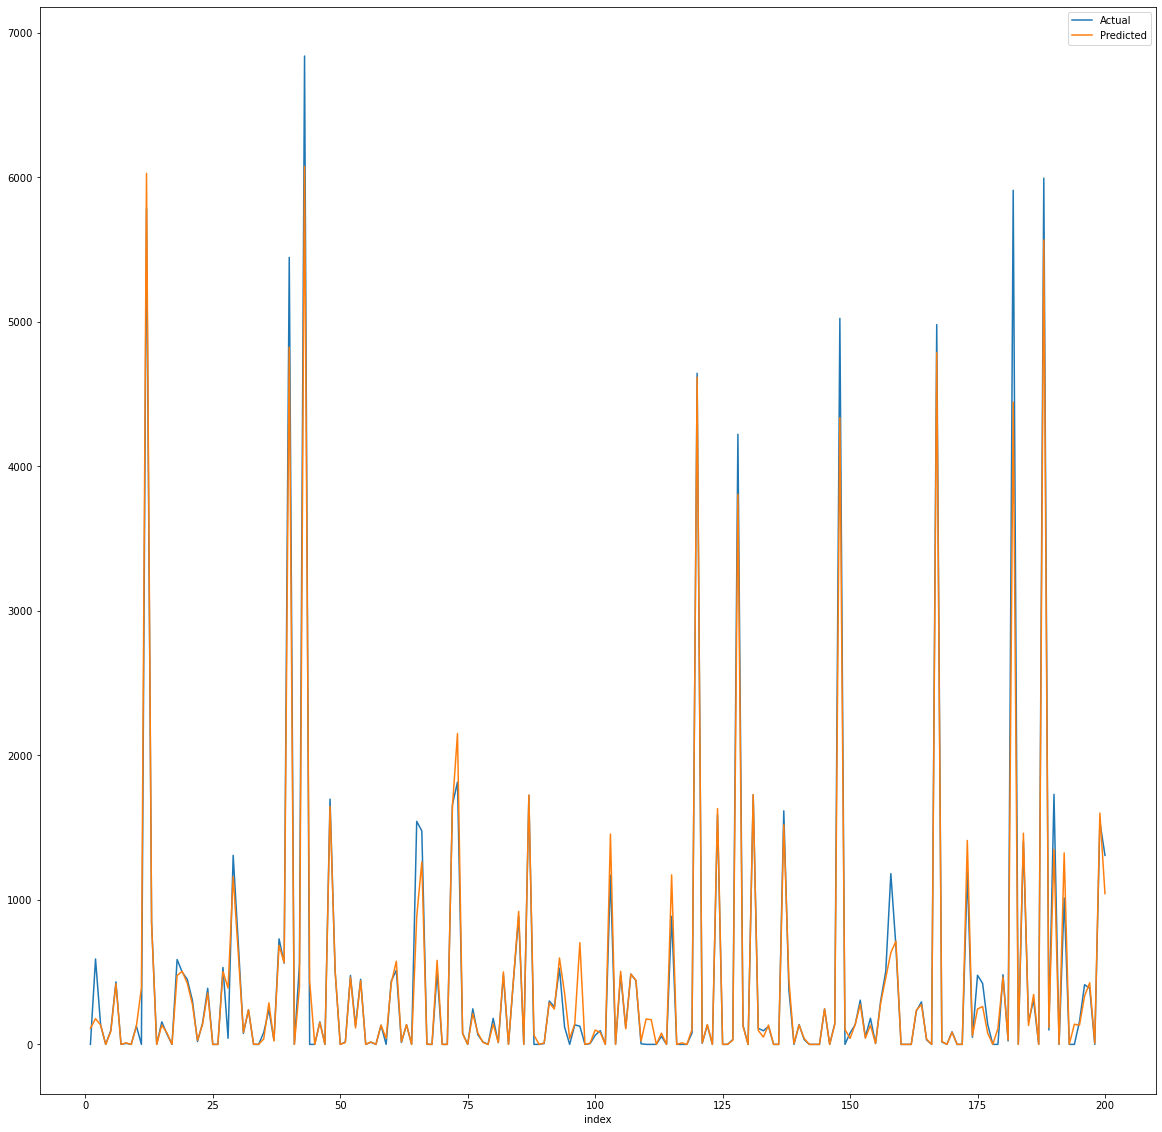

In [508]:
df_dis.plot(x = 'index', figsize = (20, 20))

In [509]:
train.describe()

,building_id,meter,meter_reading,hour,month,site_id,primary_use,square_feet,year_built,floor_count,cloud_coverage,air_temp_bellow_0,air_temp_0to18,air_temp_18to23,air_temp_above_23,dew_temp_bellow_0,dew_temp_0to13,dew_temp_above_13
count,102372.000000,102372.000000,102372.000000,102372.000000,102372.000000,102372.0,102372.000000,102372.000000,102372.000000,102372.0,102372.000000,102372.0,102372.000000,102372.000000,102372.000000,102372.000000,102372.000000,102372.000000
mean,4.996816,0.141953,456.324366,11.503605,6.647452,0.0,1.283847,44886.540206,1996.754044,1.0,4.261048,0.0,0.193901,0.237194,0.568906,0.022760,0.207068,0.770172
std,2.951760,0.349004,983.793488,6.921566,3.392764,0.0,2.316988,44836.048751,11.119680,0.0,2.392346,0.0,0.395354,0.425364,0.495232,0.149139,0.405207,0.420724
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,2720.000000,1975.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,6.000000,4.000000,0.0,0.000000,7432.000000,1989.000000,1.0,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.000000,0.000000,80.000000,12.000000,7.000000,0.0,0.000000,27000.000000,2000.000000,1.0,4.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,7.000000,0.000000,425.000000,18.000000,10.000000,0.0,0.000000,60809.000000,2004.000000,1.0,6.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,9.000000,1.000000,8442.000000,23.000000,12.000000,0.0,6.000000,121074.000000,2010.000000,1.0,9.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
